# Modelling Overview (Regression)


This is a set of personal notes on regression models used in data science for future reference. The goal is to discuss the main features of a number of regression algorithms without going into too much detail, and demonstrate how they are implemented in python. Since this is intended for my own personal use, the questions and confusions I address will be unique to my own background and experience. Nonetheless, I hope that others studying to enter data science will find this a convenient reference in their own data science journeys. Questions and comments are always appreciated! For those that found this notebook useful, I also recommend refering to my notes on classification algorithms, found [here](https://www.kaggle.com/michaelgeracie/modelling-overview-classification).

We will use the following conventions throughout. The training data is given by a set of $m$ numerical features $\mathbf x_j \in \mathbb R^n$ where $j = \{ 1 , \dots , m \}$. We will sometimes denote feature vectors using the bold face vector notation just given, and sometimes use components. The $i$th feature of the $j$th training sample is then $x_{ij} = (\mathbf x_j )_i$ where $i \in \{ 1 , \dots , n\}$. The features may be real valued or categorical, and if the $i$th feature is categorical, that component will be labelled by some subset $ C \subseteq \mathbb Z$ of the integers. 

## 1) Linear Regression
## 2) Ridge Regression
## 3) Lasso Regression
## 4) Decision Trees
## 5) Random Forests
## 6) Support Vector Regression
## 7) XGBoost Regression

The following is the standard code to start up a notebook

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # for creating plots

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Linear Regression

In linear regression we seak to predict a dependent variable $y$ as a linear function of the independent variables $\mathbf x$

\begin{align}
    y = \beta_0 + \beta_1 x_1 + \cdots \beta_n x_n.
\end{align}

It is customary in this setup to append a $1$ onto the feature fector so that $\mathbf x = ( 1 ~ x_1 ~ \cdots ~ x_n)^T$, the coefficients are then $\mathbf \beta = ( \beta_0 ~ \beta_1 ~ \cdots ~ \beta_n )^T$ and we have

\begin{align}
    y = \mathbf \beta^T \mathbf x .
\end{align}

Given some training data, we seek to choose a "best" $\mathbf \beta$ where by best we mean that it minimizes some loss function. By far the most common loss function, and the one used exclusively by `sklean.LinearRegression` is the sum of squares

\begin{align}
    L(\mathbf \beta ) &= \frac 1 m \sum_{j=1}^m ( \mathbf \beta^T \mathbf x_j- y_j)^2 
    = \frac 1 m || X \beta - y ||^2
\end{align}

where $\mathbf y = ( y_1 ~ \cdots ~ y_m)^T$ and $X_{ji} = (\mathbf x_j)_i = x_{ij} $ is a $m \times n$ matrix. That is, we compare each data point in the training set to the models prediction, square the difference, and take the average. This is distinguished from ridge and lasso regression, covered later in this notebook, by the lack of a "regularization term" intended to suppress the magnitude of the coefficients and reduce over-fitting.

The argmin of the loss function is given by the closed form expression

\begin{align}
    \mathbf \beta = (X^T X)^{-1} X^T \mathbf y .
\end{align}

See [wiki](https://en.wikipedia.org/wiki/Linear_regression#:~:text=In%20statistics%2C%20linear%20regression%20is,as%20dependent%20and%20independent%20variables) or [sklearn](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) for details.

The fit to the data is often measured by the so-called $R^2$. This is defined as

\begin{align}
    R^2 = 1 - \frac{u}{v} .
\end{align}

Here $u$ is the loss function evaluated on the training data. In the above formula, this is measured relative to the scale

\begin{align}
    v = \frac 1 m \sum_{j=1}^m  ( y_j- y_\text{mean})^2
\end{align}

for a unitless measure. Note that $R^2 \leq 1$ and an $R^2$ of $1$ indicates a perfect fit. It may however go arbitrarily negative as the fit gets worse. Note that it has been normalized so that a straight line through the mean $y = y_\text{mean}$ has $R^2 = 0$.

### Pros
* Simplicity

### Cons

* Loss function sensitive to outliers
* Loss function not unit free, so the model will be sensitive to errors that are large in magnitude, even if they represent a small percentage error
* computationally expensive since need to invert the matrix $X^T X$, which takes time of order $O(n_\text{samples} n_{features}^2)$
* if have highly correlated features (a common situation when there are a large number of parameters), the model can be highly sensitive to random errors since $det (X^T X)$ nearly $0$. The computation of the inverse is then highly sensitive to these errors and performance can be easily affected. This problem is often refered to as called "multicollinearity"
* if $n_\text{samples} < n_\text{features}$ do not have enough info to fit the model we since need to invert singular matrix

The multi-collinearity problem can be solved by using gradient descent to find the best fit, removing features with high collinearity, or using one of the regularized models introduced below.

## Example

As an example we use data from the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) challenge. Below we import the data and isolate a few numerical features to use for modelling. We also apply a standard scaler to the data before processing.

In [2]:
#import necessary methods
from sklearn.preprocessing import StandardScaler

#loading the data and and preparing our dataset
#since this is just a simple example we wont be doing and feature engineering, just drop the null values
our_features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','SalePrice']
dataset = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
dataset = dataset[our_features].dropna().to_numpy()

#our train/test split
X, y = dataset[:,:-1], dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

#the code below prefers y_train and y_test as column vectors
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#scaling the data
#linear regression is more robust if the data is scaled
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

Here we train the model and take a look at the coefficients.

In [3]:
#loading the needed modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

#train the model
regr = LinearRegression()
regr.fit(X_train_scaled,y_train_scaled)

#make predictions and evaluate our results
y_pred_scaled = regr.predict(X_test_scaled)
print('The mean-squared-error on the test data: ',mean_squared_error(y_test_scaled,y_pred_scaled))
print('R-squared of the fit: ',r2_score(y_test_scaled,y_pred_scaled))
print()

#retrieve the coefficientes that define the model
print('The intercept and slope coefficients that define the model:')
print(regr.intercept_)
print(regr.coef_)

The mean-squared-error on the test data:  0.186032063508394
R-squared of the fit:  0.7362759206661226

The intercept and slope coefficients that define the model:
[2.95414471e-16]
[[0.10557266 0.13455974 0.68028219 0.04316808 0.12375952]]


Of course, we would expect the intercept to be zero since we applied a scaler to the data. Note that the `OverallQual` feature is by far the most important one in this model. As we shall see, ridge and lasso regression will tend to emphasize the features that are most relevant, with lasso regression in particular completely discarding features it deems much less important than the others.

For now, let's simply take the model as given us and plot it against the training data for a single feature to see how we did. Note that if we want the data in the original scale, we need to scale it back. Suppose $\tilde x$ and $\tilde y$ are a pair of scaled independent and dependent variables respectively
\begin{align}
    x = s_x \tilde x + \bar x , \nonumber \\
    y = s_y \tilde y + \bar y .
\end{align}
Here the barred variables denote the means and the scales $s_x$ and $s_y$ are chosen so that $\tilde x$ and $\tilde y$ have unit variance. The model built on the scaled data gives $\tilde y = m \tilde x$. Hence for the unscaled variables we have
\begin{align}
    y = m \frac{s_y}{s_x} x + \bar y - \bar x m \frac{s_y}{s_x} .
\end{align}

Below we simply set the less relevant features to zero for the sake of getting a one-dimensional plot, which isn't great practice since this model was designed to depend on these variables. A one-dimensional model is actually pretty good for this data though and indeed will be automatically generated by a lasso regressor with large enough regularization parameter $\alpha$.

Best fit line: y = -71875.81643886378 + 41269.47183330111 x


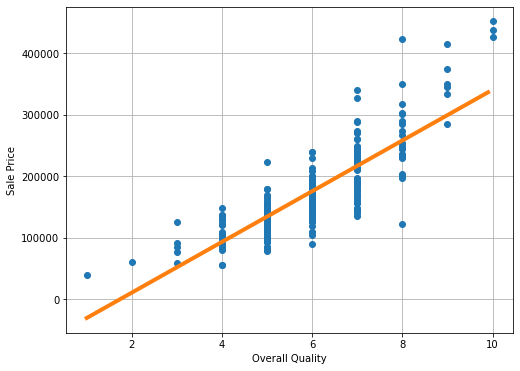

In [4]:
#set up the plot
plt.figure(figsize=(8,6))
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.grid(True)

#plot the test data using the most relevant feature
plt.plot(X_test[:,2],y_test,'o')

#convert back to original scale and plot
intercept = scaler_y.mean_[0] - scaler_X.mean_[2] * regr.coef_[0][2] * scaler_y.scale_[0] / scaler_X.scale_[2]
slope = regr.coef_[0][2] * scaler_y.scale_[0] / scaler_X.scale_[2]
print('Best fit line: y =',intercept,'+',slope,'x')

xx = np.arange(1,10,.1)
yy = intercept + slope * xx
plt.plot(xx,yy,linewidth=4.0)
plt.show()

# Ridge Regression

For data with large numbers of features, multicollinearity can be a pretty serious problem. By adding a regularizing term to the loss function we can diminish this problem at the cost of some bias. For ridge regression we use the loss function

\begin{align}
    L(\mathbf \beta ) =||X \beta - y||_2^2 + \alpha || \beta ||_2^2.
\end{align}

Here $||\mathbf x||_p = \left( \sum_{i=1}^n x_i^p\right)^{1/p}$ is the so-called $L^p$ norm on $\mathbb R^n$.
The regularization term counters the tendancy for $\beta$ to become too large when we have multi-collinearity: we would like to diminish the dependence on the less important feature. The optimal weight vector is given by

\begin{align}
    \beta = (X^T X - \alpha)^{-1} X^T y .
\end{align}

We see that $\alpha$ adds a small amount to the diagonal of the matrix to be inverted, making it less singular and reducing the risk of collinearity.

## Geometric Interpretation
    
The regularization term has a useful geometric interpretation that will help in our understanding of lasso regression. Consider the alternate constrained optimization problem

\begin{align}
    \text{minimize} ~ &L(\mathbf \beta ) =||X \beta - y||_2^2 \nonumber \\
    \text{subject to} ~ &|| \beta ||_2^2 \leq t
\end{align}

This minimization problem prevents $\beta$ from being too large, as a result, certain features are deemphasized and only the most important ones are given weight.

It turns out this optimization problem is related to the one given above. Carrying out the minimization proceedure we find that

\begin{align}
    \beta = (X^T X)^{-1} X^T y
\end{align}

if the minimum is such that $||(X^T X)^{-1} X^T y ||_2^2 \leq t$. If the minimum value of $\beta$ is such that it does not lie within the ball of radius $t^{1/2}$, then the best we can do in the inequality constrained optimization problem is to be on the boundary. That is, the problem becomes a constrained optimization problem, solved by introducing lagrange multipliers

\begin{align}
    L = ||X \beta - y||_2^2 + \alpha (||\beta||_2^2 - t) .
\end{align}

Minimizing this we have

\begin{align}
    &|| \beta ||_2^2 - t = 0 , \nonumber \\
    &\beta = (X^T X - \alpha)^{-1} X^T y .
\end{align}

There is a unique $\alpha$ for which this can be solved, which we denote $\alpha_t$.

Hence, the constrained problem gives the solution to the least-mean-squares problem if $\beta$ doesn't get too big. However, when the minimum is far enough away from the origin, the problem is equivalent to ridge regression where the regularization parameter of ridge regression is related to $t$ in some way. Note that this relationship is dependent on the training data $(X,y)$. In the ridge regression problem, for $\beta_\text{LMSE}$ sufficiently far out, we get a $\beta$ lying on the surface of the sphere of radius-squared $t_\alpha$.

We'll delay the example for ridge regression until we have also covered lasso regression since it is instructive to compare them.


# Lasso regression

Lasso regression is the same as ridge regression, but with a different measure for the regularization term. Again, see [here](https://scikit-learn.org/stable/modules/linear_model.html#lasso) or [wiki](https://en.wikipedia.org/wiki/Lasso_(statistics)) for details. The loss function to be minimized is

\begin{align}
    L ( \beta ) = \frac{1}{2 n_\text{samples}} || X \beta - y ||_2^2 + \alpha || \beta ||_1,
\end{align}

introducing an $L^1$ norm cost to the slope of the linear model.

The idea behind this loss function can be more easily understood given the geometric interpretation above. For $||\beta||_1$ sufficiently large, this is equivalent to the constrained optimization problem

\begin{align}
    \text{minimize} ~ &L(\mathbf \beta ) =||X \beta - y||_2^2 \nonumber \\
    \text{subject to} ~ &|| \beta ||_1 \leq t
\end{align}

where there is some relationship between $\alpha$ and $t$ which isn't important. The advantages of this metric come from the shape of the region $\|| \beta ||_1 \leq t$, which is a $n$-dimensional hypercube centered at the origin with vertices on the axes. The fact that the vertices are on the axes and edges on zero planes is the essential point: $\beta$ will try to get as close as it can (in the $L^2$-norm) to the value given by minimizing the LMSE subject to being on this cubical surface. That will tend to be near vertices or edges, which extend farther from the origin in the $L^2$-norm, but tend to lie on zero planes, thus setting many less important features to zero *exactly*, while emphasizing the more important ones (compared to ridge regression). The geometric intuition can be seen pictured below.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/L1_and_L2_balls.svg">

Hence the regularization not only improves generalizability of the model by discouraging over-fitting, it also aids in the interpretability of a model with a complicated feature set by exactly discarding the least important features.

Note that since lasso has no closed form expression for the optimal coefficient vector, this is found via gradient descent.

# Example (Linear vs Ridge vs Lasso)

Finally, let's return to the example that we used in standard linear regression, drawing on data from the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. We will use the same data as before, see above for the preparation.

To begin with, let's just create a ride model and see how it does. Feel free to play around with the $\alpha$ parameter. We show how to retrieve the intercept and slope parameters (of course since we are working with the scaled data the intercept is expected to be zero) and evaluate the fit using the MSE and $R^2$.

In [5]:
#import the model
from sklearn.linear_model import Ridge

#train the model
regr = Ridge(alpha=1.0)
regr.fit(X_train_scaled,y_train_scaled)

#make a prediction
y_pred_scaled = regr.predict(X_test_scaled)

#retrieve parameters of the model and evaluate the fit
print('Intercept: ',regr.intercept_[0])
print('Slope: ',regr.coef_[0])
print('The mean-squared-error on the test data: ',mean_squared_error(y_test_scaled,y_pred_scaled))
print('R-squared of the fit: ',r2_score(y_test_scaled,y_pred_scaled))

Intercept:  2.9566423266418846e-16
Slope:  [0.10568036 0.13452632 0.67928136 0.04316701 0.12421336]
The mean-squared-error on the test data:  0.18585837722158133
R-squared of the fit:  0.7365221430388618


Now let's do the same with a lasso regressor.

In [6]:
#import the model
from sklearn.linear_model import Lasso

#train the model
regr = Lasso(alpha=0.1)
regr.fit(X_train_scaled,y_train_scaled)

#make a prediction
y_pred_scaled = regr.predict(X_test_scaled)

#retrieve parameters of the model and evaluate the fit
print('Intercept: ',regr.intercept_[0])
print('Slope: ',regr.coef_)
print('The mean-squared-error on the test data: ',mean_squared_error(y_test_scaled,y_pred_scaled))
print('R-squared of the fit: ',r2_score(y_test_scaled,y_pred_scaled))

Intercept:  1.0044136291952724e-16
Slope:  [ 0.0510187   0.06467139  0.65555499 -0.          0.03090961]
The mean-squared-error on the test data:  0.19951809558940128
R-squared of the fit:  0.71715775723044


It's insructive to see how each model behaves as a function of the regularization parameter. Here we plot the coefficients and $R^2$ as a function of $\alpha$.

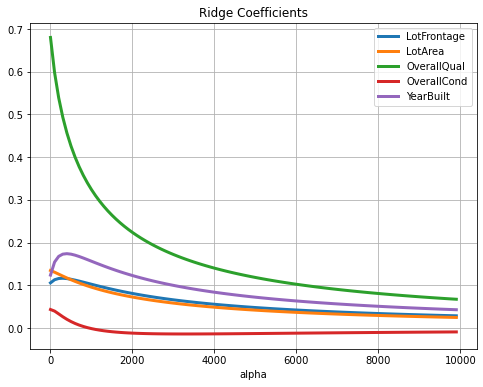

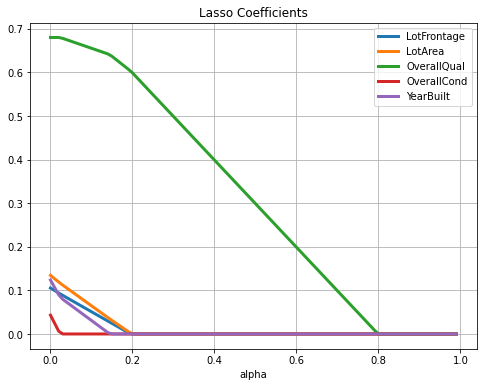

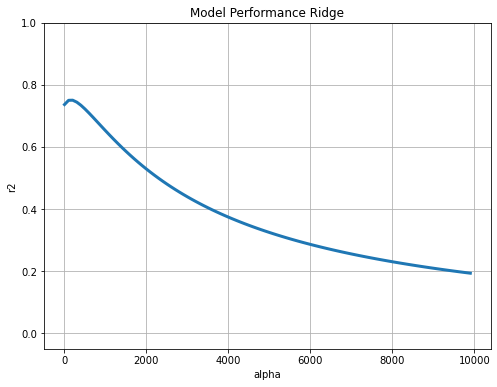

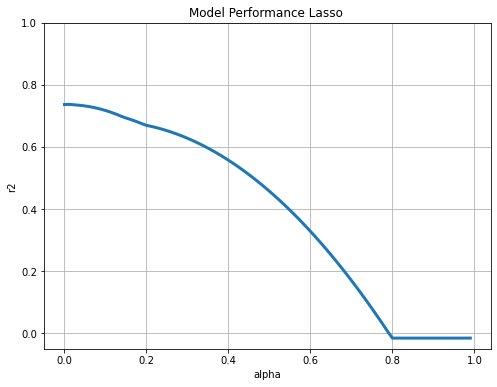

In [7]:
#the range of parameters we test for ridge regression
alpha_max_r = 10000.0
step_r = 100
alpha_grid_r = np.arange(0.00001, alpha_max_r, step_r)

#the range of parameters we test for lasso regression
alpha_max_l = 1.0
step_l = .01
alpha_grid_l = np.arange(0.00001, alpha_max_l, step_l)

#create some lists to store the coefficients and r^2 values
coef_grid_r = []
r2_grid_r = []

coef_grid_l = []
r2_grid_l = []

#iterate through the allowed values of alpha, train a model for each, and store that models values for the coefficients and for R^2
#do this once for ridge
for alpha in alpha_grid_r:    
    regr = Ridge(alpha=alpha)
    regr.fit(X_train_scaled,y_train_scaled)
    
    y_pred_scaled = regr.predict(X_test_scaled)
    coef_grid_r.append(regr.coef_.tolist()[0])
    r2_grid_r.append(r2_score(y_test_scaled,y_pred_scaled))

#and once for lasso
for alpha in alpha_grid_l:    
    regr = Lasso(alpha=alpha)
    regr.fit(X_train_scaled,y_train_scaled)
    
    y_pred_scaled = regr.predict(X_test_scaled)
    coef_grid_l.append(regr.coef_)
    r2_grid_l.append(r2_score(y_test_scaled,y_pred_scaled))

#now we make some plots to demonstrate the behavior of the coefficients and R^2 as a function of alpha for both ridge and lasso regression
#parameters for the plots
linewidth = 3.0
figsize = (8,6)

#coefficients vs. alpha for Ridge
plt.figure(figsize=figsize)
plt.plot(alpha_grid_r,coef_grid_r,linewidth=linewidth)
plt.xlabel('alpha')
plt.title('Ridge Coefficients')
plt.legend(our_features);
plt.grid(True)
plt.show()

#coefficients vs. alpha for Lasso
plt.figure(figsize=figsize)
plt.plot(alpha_grid_l,coef_grid_l,linewidth=linewidth)
plt.xlabel('alpha')
plt.title('Lasso Coefficients')
plt.legend(our_features);
plt.grid(True)
plt.show()

#R^2 vs alpha for Ridge
plt.figure(figsize=figsize)
plt.plot(alpha_grid_r,r2_grid_r,linewidth=linewidth)
plt.ylim(-0.05,1)
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title('Model Performance Ridge')
plt.grid(True)
plt.show()

#R^2 vs alpha for Lasso
plt.figure(figsize=figsize)
plt.plot(alpha_grid_l,r2_grid_l,linewidth=linewidth)
plt.ylim(-0.05,1)
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title('Model Performance Lasso ')
plt.grid(True)
plt.show()

Yes, ridge regression does perform better. However, at a very low cost to performance, we get a far simpler model from lasso regression: the model knows that overall quality is far more important than any other feature we've included and builds a model using only this feature once $\alpha$ has been set high enough. Let's take this simple model and evaluate it's performance

Lasso parameter alpha:  0.2
The Coefficients:  [ 0.         0.         0.5990595 -0.         0.       ]
The R-squared score:  0.6693280518097087

Best fit line: y = -41495.36166695412 + 36342.07927019361 x


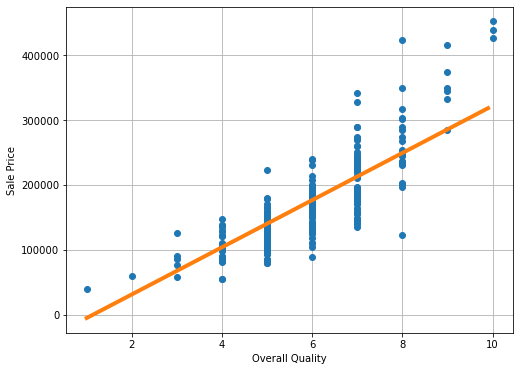

In [8]:
#training the lasso regressor at a value of alpha large enought to result in a simple model, but small enough to not underfit
alpha = 0.2
regr = Lasso(alpha=alpha)
regr.fit(X_train_scaled,y_train_scaled)
    
#use it to make some predictions, retrieve its coefficients, and evaluate its performance
y_pred_scaled = regr.predict(X_test_scaled)
print('Lasso parameter alpha: ',alpha)
print('The Coefficients: ',regr.coef_)
print('The R-squared score: ',r2_score(y_test_scaled,y_pred_scaled))
print()

#set up the plot
plt.figure(figsize=(8,6))
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.grid(True)

#plot the test data
plt.plot(X_test[:,2],y_test,'o')

#convert linear model back to original scale and plot
intercept = scaler_y.mean_[0] - scaler_X.mean_[2] * regr.coef_[2] * scaler_y.scale_[0] / scaler_X.scale_[2]
slope = regr.coef_[2] * scaler_y.scale_[0] / scaler_X.scale_[2]
print('Best fit line: y =',intercept,'+',slope,'x')

xx = np.arange(1,10,.1)
yy = intercept + slope * xx
plt.plot(xx,yy,linewidth=4.0)
plt.show()

# Decision Tree Regression

Our main source for learning about decision tree regression may be found [here](https://www.saedsayad.com/decision_tree_reg.htm#:~:text=Decision%20tree%20builds%20regression%20or,decision%20nodes%20and%20leaf%20nodes.).
For those that want a bit more detail, we also refer to [here](https://sefiks.com/2018/08/28/a-step-by-step-regression-decision-tree-example/).

Decision tree regressors are constructed in same way as classifiers,generating a tree according to a top-down greedy strategy. Hence we will be brief in our outline and refer to our [classification notebook](https://www.kaggle.com/michaelgeracie/modelling-overview-classification) for more details. Starting from the root node the algorithm checks all possible splitings and picks the one which "organizes" the data the best, that is, leads to the most homogeneous branches. Homogeneity is measured by some impurity measure which we hope to minimize. `sklearn`'s implementation gives three choices for this impurity measure, fixed by the `criterion` parameter, the mean-squared-error (`'mse'`), the mean-absolute-error (`'mae'`), and the Friedman mean-squared error (`'friedman_mse'`) (we'll skip this one for now). The first two are simply the $L^2$ and $L^1 norms of the error

\begin{align}
    H(Q) = \sqrt ( \frac 1 n \sum_Q (y - \bar y)^2 ),
    \qquad \text{or} \qquad
    H(Q) = \frac 1 n \sum_Q | y - \bar y |
\end{align}

where $\bar y$ is the mean of the training data and the sum is over all training samples $Q$ that fall into the resulting leaf. The $L^2$ error is of course just the standard deviation. The "gain" of a split is given by

$$G(Q,\theta)= H(Q) - \frac{|Q_\text{L} (\theta)|}{|Q|} H (Q_\text{L} (\theta)) - \frac{|Q_\text{R} (\theta)|}{|Q|} H (Q_\text{R} (\theta))$$

Here, as in our classification notebook, $\theta = (i , \theta_i)$ is a split of the $i$th feature into sets of training data with that feature greater than or less than $\theta_i$. These sets are denoted as

$$Q_\text{L} (\theta) = \{ j \in Q | x_{ij} \leq \theta_i \} ,$$
$$Q_\text{R} (\theta)= \{ j \in Q | x_{ij} > \theta_i \} .$$

We then iterate through the tree as in the classification problem, choosing the best split, that is the one maximizing the gain at each stage until we are out of features, every leaf is homogeneous, or a stopping condition has been reached. In the end, we have a decision tree that has organized the data into more homogeneous leaves. The numerical value for $y$ returned by the regressor given a feature vector $\mathbf x$ is found by following $\mathbf x$ to it's given leaf and taking the average of all samples in the leaf.

## Example

Let's do the same housing price example but now with a decision tree regressor. Another excellent demonstration is given [here](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html). Let's first load and prepare the data

In [9]:
#loading the data and and preparing our dataset
#since this is just a simple example we wont be doing and feature engineering, just drop the null values
our_features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','SalePrice']
dataset = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
dataset = dataset[our_features].dropna().to_numpy()

#our train/test split
X, y = dataset[:,:-1], dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

#the code below prefers y_train and y_test as column vectors
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#scaling the data helps performance since our loss function is unitful
#this helps to decrease the imporance of outliers and otherwise prevent over-fitting
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

Below we can see how to train the model in python. For pedagogical purposes, we have used a model with some pruning. Without it the tree is massive.

In [10]:
#loading the needed modules
from sklearn.tree import DecisionTreeRegressor

#train the model
tree = DecisionTreeRegressor(criterion='mse',min_impurity_decrease=.05)
tree.fit(X_train_scaled,y_train_scaled)

#make predictions and evaluate our results
y_pred_scaled = tree.predict(X_test_scaled)
print('The mean-squared-error on the test data: ',mean_squared_error(y_test_scaled,y_pred_scaled))
print('R-squared of the fit: ',r2_score(y_test_scaled,y_pred_scaled))
print()

The mean-squared-error on the test data:  0.25048686633896605
R-squared of the fit:  0.6449030507717227



Let's take a look at the tree to see how it makes decisions

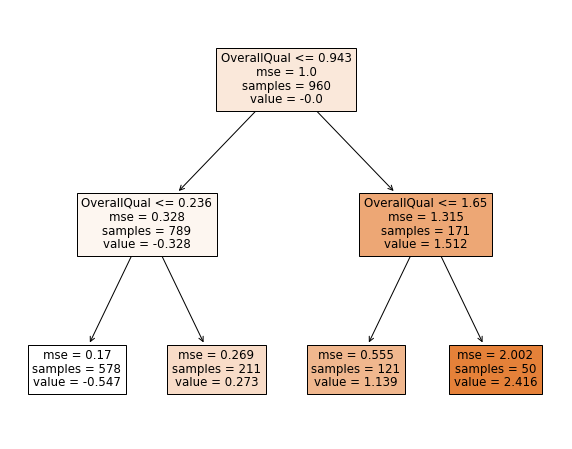

In [11]:
#as well as displaying them
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(10,8))
plot_tree(tree, 
            feature_names=our_features, 
            filled=True)
plt.show()

The model has correctly deduced that the overall quality is the most important feature, and given the high level of purning we have specified, this is the only feature that it uses to make decisions. Let's plot it's predictions vs this feature.

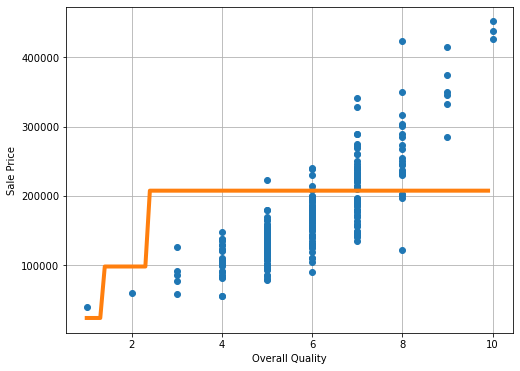

In [12]:
#set up the plot
plt.figure(figsize=(8,6))
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.grid(True)

#plot the test data
plt.plot(X_test[:,2],y_test,'o')


xx = np.arange(1,10,.1)
zeros = np.zeros(len(xx)).reshape(-1,1)
graph_x = np.concatenate((zeros,zeros,xx.reshape(-1,1),zeros,zeros),axis=1)
yy = scaler_y.scale_[0] * tree.predict( graph_x / scaler_X.scale_[2])
plt.plot(xx,yy,linewidth=4.0)
plt.show()

Not a great fit, but we of course are using a pretty trivial example of a decision tree so that we could understand it better. With highly collinear features and non-linear, interactive behavior, we generally expect a decision tree model to perform better than linear regression and its variants.

# Random Forest Regression

A random forest regressor works almost exactly the same as a random forrest classifier, so we will simply recap much of our discussion from our [classification notebook](https://www.kaggle.com/michaelgeracie/modelling-overview-classification) here.

A random forest regressor is an ensemble algorithm constructed from a large number of randomly generated decision tree regressors. This randomness greatly reduces variance in the predictions at a slight cost in bias and so is a good way to prevent overfiting. Randomness is introduced to the model in two ways:

1) Only train on a randomly selected subset of the training data (with replacement). This is called "bootstraping" and is a general method to generate "new data" for training to create lower variance models. Sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True`. This can be an integer number of samples, or a float between 0 and 1, in which case it is interpreted as a fraction of samples to use from the training data.

2) In training each tree, only use a randomly selected subset of features of size `max_features` when deciding on how to split a node.

Numerical results from the different decision trees are then averaged weighted by the probability that each tree gives for being in each class of the classification problem. This is called 'bagging'. A more detailed discussion of random forests can be found [here](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees) and [here](https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImUxOTdiZjJlODdiZDE5MDU1NzVmOWI2ZTVlYjQyNmVkYTVkNTc0ZTMiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MDc5NzU0NTksImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjEwODUyOTk4NDAxNjg4MDI5Mzk3NyIsImVtYWlsIjoibWljaGFlbC5nZXJhY2llQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiTWljaGFlbCBHZXJhY2llIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hLS9BT2gxNEdqNml0b0lrMnF0RmhjaTU1NXlIT0x3S1l5RURqLTVLRmZUYmxyMD1zOTYtYyIsImdpdmVuX25hbWUiOiJNaWNoYWVsIiwiZmFtaWx5X25hbWUiOiJHZXJhY2llIiwiaWF0IjoxNjA3OTc1NzU5LCJleHAiOjE2MDc5NzkzNTksImp0aSI6ImNhNDQxZTQ2NDRlYmU3NzA4NmZkNWM2ZTQzMGZmMzdiYjhlZTA3MjcifQ.q06UvOQMSzvqBMNFyilXHbzbBqrzAoQZuoLEaqAJkVUUZChCKyRnqDzyZYyWzxVT7g25MK36TacYd9vONK4o10YoztIJfqQIINXGHDgnC03BGchNce06BK_9zajYcdJ--sjDJzpcP0sOwFoTnVNlRfHbi59HCMW2XxqLV8T2GwDJOPKNItzUa05fAc7sQOKvYeWR_rla_nI5V1FffBlRFzgG9eC2QaaLhRw3N_Bk5TC-QpnhFXO8IXDCrPkXR8EhxcIR20bpq8xwwdMO5kVLO-1nVeeRHsB-Xzic0N0uF6d20BP9R6cEYvHpX9hbbnRTQq5Q-44BHWwiBFH6V62llA)

## Example

We use the same data from the housing prices competition. Here we load the data and perform a train/test split

In [13]:
#loading the data and and preparing our dataset
#since this is just a simple example we wont be doing and feature engineering, just drop the null values
our_features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','SalePrice']
dataset = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
dataset = dataset[our_features].dropna().to_numpy()

#our train/test split
X, y = dataset[:,:-1], dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

Now we build a random forest model. Here `n_estimators` is number of trees trained in the ensemble, `criterion` is the measure of information gain used in assembling each tree, and `max_samples` is the percentage of samples used in training each tree and `max_features` is the number of features used. There are many pruning parameters given in the documentation. We will use `min_samples_leaf` for no particular reason.

In [14]:
#creating and training the model
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(
    n_estimators=100,
    criterion='mse',
    max_samples=0.3,
    max_features=3,
    min_samples_leaf=3,
    random_state=0)
regr.fit(X_train,y_train)

#making predictions and evaluating performance
y_pred = regr.predict(X_test)
print('The mean-squared-error: ', mean_squared_error(y_test,y_pred))
print('The r-squared value: ', r2_score(y_test,y_pred))

The mean-squared-error:  1068789554.9614059
The r-squared value:  0.7944383786554998


# Support Vector Regression

Support vector regression models are very similar to support vector classification models in the underlying mathematics, but the interpretation of what is being done is quite different. Rather than creating a "domain wall" that seperates two classes as well as possible by trying to maximize the size of the marginal region between them, our goal is to create a line (or curve once implementing the kernel trick) such that the training data is as close as possible to the line while keeping the slope low (curve smooth). An excellent overview of the proceedure can be found [here](https://www.mathworks.com/help/stats/understanding-support-vector-machine-regression.html).

We will introduce non-linearity with the kernel trick later on. For now we work with the linear mode. Let $\epsilon$ be a given constant. The goal is to find a line

\begin{align}
    y = \mathbf w^T \mathbf x + b
\end{align}

with minimal slope

\begin{align}
    \frac 1 2 || \mathbf w ||^2_2
\end{align}

such that all data points are within distance $\epsilon$ of th line

\begin{align}
    | y_j - (\mathbf w^T \mathbf x_j + b | \leq \epsilon .
\end{align}

### The primal problem

Obviously, given $\epsilon$, this is not always possible. Hence, as in a soft support vector classifier, we "soften" the problem by introducing slack variables $\xi_j$ and $\xi^*_j$ that parameterize how much a sample data point is above or below the $\epsilon$-window introduced above

\begin{align}
    y_j - (\mathbf w^T \mathbf x_j + b ) &\leq \epsilon + \xi_j ,\nonumber \\
    y_j - (\mathbf w^T \mathbf x_j + b ) &\geq - \epsilon - \xi^*_j , \nonumber \\
    \xi_j &\geq 0 , \nonumber \\
    \xi^*_j &\geq 0 .
\end{align}

and induce a cost for them with a positive parameter $C$

\begin{align}
    L ( w , b , \xi , \xi^* ) = \frac 1 2 || \mathbf w ||^2 + C \sum_{j = 1}^m \left( \xi_j + \xi^*_j\right) .
\end{align}

This constrained optimization problem is the so-called primal problem.

### The dual problem

Again, we refer to our notes on "Constraints, Lagrange Multipliers, and Duality" for how to pass to the dual problem. In the end, we find that the dual lagrangian is

\begin{align}
    Q(\mathbf \alpha, \mathbf \alpha^* ) = - \frac{1}{2} \sum_{i =1}^m \sum_{j=1}^m (\alpha_i - \alpha^*_i )(\alpha_j - \alpha_j^* ) \mathbf x^T_i \mathbf x_j - \epsilon \sum_{j=1}^m ( \alpha_j + \alpha^*_j ) + \sum_{j=1}^m y_j (\alpha_j - \alpha_j^* ) .
\end{align}

Here $\alpha_j$ is the lagrange multiplier that enforces $y_j - (\mathbf w^T \mathbf x_j + b ) \leq \epsilon + \xi_j$ and $\alpha^*_j$ enforces $y_j - (\mathbf w^T \mathbf x_j + b ) \geq - \epsilon - \xi^*_j$. The dual lagrangian should be maximized subject to the constraints

\begin{align}
    0 \leq \alpha_j \leq C,
    \qquad 0 \leq \alpha^*_j \leq C ,
    \qquad \sum_{j=1}^m ( \alpha_j - \alpha_j^* ) = 0 .
\end{align}


The optimal line is then given by

\begin{align}
    \mathbf w = \sum_{j=1}^m ( \alpha_j - \alpha^*_j ) \mathbf x_j , \nonumber \\
    b = y_j - \mathbf w^T \mathbf x_j - \epsilon
\end{align}

where the $j$ in the equation for $b$ is any $j$ such that $0 < \alpha_j < C$ so that the two inequality constraints $\xi_j=0$ and the $y_j - (\mathbf w^T \mathbf x_j + b ) = \epsilon$ are saturated.

Note that the line only depends on points for which $\alpha_j - \alpha^*_j \neq 0$. In analogy with the classification case, these $j$'s are called support vectors. They are data points close enough to the curve to either lie on the the $\epsilon$ boundary or induce some cost by impinging into it.

### The kernel trick
As with support vector classifiers, we see that in the end the model depends only on the Gram matrix of inner products $G_{ij} = \mathbf x^T_i \mathbf x_j$. We can make a non-linear model by replacing this with a kernel $K(\mathbf x , \mathbf y)$ which is interpreted as the inner product in a higher-dimensional space that has been non-linearly mapped to. We can save a lot of computational time by not actually mapping to this higher dimensional space, but simply using the expression for the resulting inner product. We then have lagrangian

\begin{align}
    Q(\mathbf \alpha, \mathbf \alpha^* ) = - \frac{1}{2} \sum_{i =1}^m \sum_{j=1}^m (\alpha_i - \alpha^*_i )(\alpha_j - \alpha_j^* ) K (\mathbf x_i ,\mathbf x_j )- \epsilon \sum_{j=1}^m ( \alpha_j + \alpha^*_j ) + \sum_{j=1}^m y_j (\alpha_j - \alpha_j^* ) .
\end{align}

in the dual problem and after maximation, the ideal curve is given by

\begin{align}
    y = \sum_{j=1}^m ( \alpha_j - \alpha^*_j) K ( \mathbf x_j , \mathbf x ) + b
\end{align}

with $b$ given by
\begin{align}
    b = y_j - \sum_{k=1}^m (\alpha_k - \alpha^*_k ) K ( \mathbf x_k , \mathbf x_j ) - \epsilon ,
\end{align} 
for a vector $j$ with $0 < \alpha_j < C$.

Some common kernels built into `sklearn` are:

* `linear`: $K_(\mathbf x_i , \mathbf x_j ) = \mathbf x_i^T \mathbf x_j$
* `poly`: $K_(\mathbf x_i , \mathbf x_j ) = (\gamma x_i^T \mathbf x_j + r )^d$
* `rbf`: $K_(\mathbf x_i , \mathbf x_j ) = \exp \left(- \gamma || x_i - x_j ||^2_2 \right)$
* `sigmoid`: $K_(\mathbf x_i , \mathbf x_j ) = \tanh \left(\gamma || x_i - x_j ||^2_2 + r \right)$

Here $\gamma$ is always set by parameter `gamma`, $r$ by `coef0` and $d$ by `degree`. Different kernels will be good at creating classification boundaries of different shapes, but we have not investigated how they perform yet.

## Example

We take this example from [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html). In this example we generate some non-linear sample data with some random noise that we try to fit using a support vector regressor

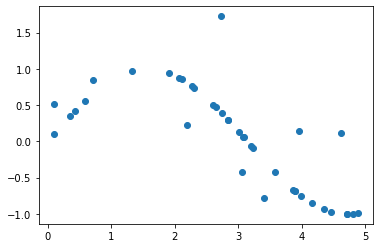

In [15]:
# #############################################################################
# Generate sample data
np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

#plot
plt.scatter(X,y)
plt.show()

Below we try to fit this with support vector models of various types. The support vectors are indicated in black

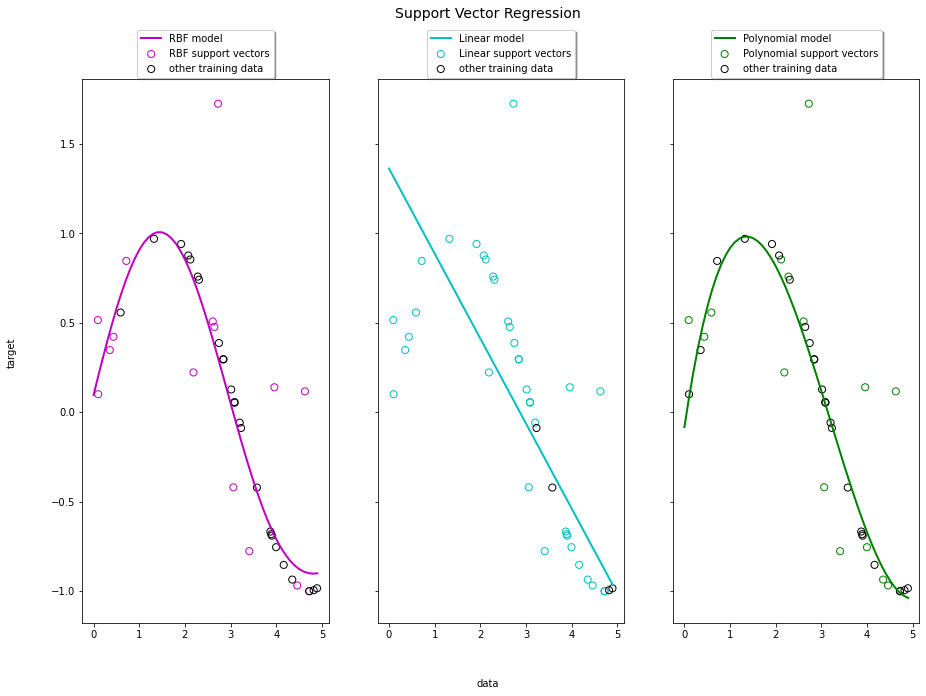

In [16]:
# #############################################################################
# Fit regression model
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel='linear', C=100,epsilon=0.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=0.1,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

x = np.arange(0,5,0.1).reshape(-1,1)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(x, svr.fit(X, y).predict(x), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

# XGBoost Regression

XGBoost regressors are basically identical to XGBoost classifiers, except whereas the trees in an XGBoost classifier are built to iteratively correct the probability of "success" (technically, they add linearly to the log-odds), the trees in an XGBoost regressor directly add their outputs to the the model's prediction for the dependent variable. There is a different loss function more appropriate for diagnosing how far off we are, but this is the only difference. As such, we simply copy and paste much of the [classification discussion](https://www.kaggle.com/michaelgeracie/modelling-overview-classification) here, making a few key changes.
For more details on this algorithm see [here](https://xgboost.readthedocs.io/en/latest/tutorials/model.html).

As usual, suppose we are given a training set $\mathbf x_{j}$ with dependent variable $y_j \in \mathbb R$. In this algorithm, our goal is to create a rule that takes a given feature vector $\mathbf x$ and outputs a prediction $y(\mathbf{x} )$ for the dependent variable.

Our plan is to build many trees $T^{(k)}$. Each tree will produce a numerical output for a given feature vector $\mathbf x$, which we denote $f^{(k)}(\mathbf x)$. The tree ensemble will be built iteratively with each tree correcting the result for $y(\mathbf{x})$ produced by all the previous trees. As such, each tree is not indidually interpretretable as it is say in a random forest. Thus we get a sequence of predictions

\begin{align}
    y^{(0)}(\mathbf{x}) &= \frac 1 2 , \nonumber \\
    y^{(1)}(\mathbf{x}) &= y^{(0)}(\mathbf{x} )+ \epsilon f^{(1)} ( \mathbf x), \nonumber \\
    &\qquad \cdots \nonumber \\
    y^{(k)}(\mathbf{x}) &= y^{(k-1)}(\mathbf{x}) + \epsilon f^{(k)}(\mathbf x ) = \frac 1 2 + \epsilon \sum_{a = 1}^k f^{(a)} ( \mathbf x )
\end{align}

with better and better accuracy (we will discuss how to measure accuracy in a bit). 

## The proceedure

The initial tree $T^{(0)}$ is just a root, sending $\mathbf x \rightarrow f^{(0)}$ (a constant typically set to $1/2$) for any input feature vector. Now suppose we are given an ensemble of trees $\{ T^{(0)}, \dots , T^{(k)} \}$ and let $y^{(k)}_j$ be it's output for each feature vector $\mathbf x_j$. We evaluate our success with an "objective function"

$$
    O = \sum_{j=1}^m L ( y_j , y^{(k)}_j) + \sum_{a=1}^k \Omega ( T^{(a)} )
$$

and try to choose the parameters for our new tree $T^{(k+1)}$ so that it's contribution to $O$ is minimized. Here $L$ is a loss function that captures how well the model matches the training data and $\Omega$ is a "regularization function" to prevent over-fitting.

## Loss and regularization
The loss function used for regression problems is

\begin{align}
    L(y(\mathbf x),y_j) &= \frac 1 2 \sum_{j=1}^m (y (\mathbf x_j) - y_j)^2 .
\end{align}

A good regularization function will be larger for "more complicated" trees, so that it's cost in the objective function prevents over-fitting.
Let $t$ be the number of leaves in a tree $T$ and let $w_b$ be the numerical outputs of each leaf with $b$ labelling the leaves. The regularization term used is

\begin{align}
    \Omega ( T ) = \gamma t + \frac 1 2 \lambda \sum_{b=1}^t w^2_b
\end{align}

for some parameters $\gamma$ and $\lambda$ which must be specified. Adding this to the objective function makes the model tend to prefer trees with a smaller number of leaves and weight more concentrated in a few of them.

## Building trees

At the end of the day though, for speed and simplicity, `XGBoost` minimizes the Taylor approximation to the objective function. Let the objective function at step $k$ be

\begin{align}
    O = \sum_{a=1}^k O^{(a)}
\end{align}

with

\begin{align}
    O^{(a)} = \sum_{b=1}^{t^{(a)}} \left( G^{(a)}_b w^{(a)}_b + \frac 1 2 ( H^{(a)}_b + \lambda ) (w^{(a)}_b)^2 \right) + \gamma t^{(a)}
\end{align}

being the contribution from the $a$th tree. Here $G_b$ and $H_b$ are the Taylor coefficients of the objective function introduced above. They are associated to each leaf of a tree and take the values

\begin{align}
    G^{(a)}_b = - \sum_j' ( y_j - y^{(a-1)}_j) ,
    &&H^{(a)}_b = \sum_j'  1.
\end{align}

Here the prime denotes that we sum over $(\mathbf x_j, y_j)$ in the training set that lie in this leaf.
In other words, the titular gradient $G^{(a)}_b$ is the sum of the "residues" of the training data points that lie in the $b$th leaf.

Now let's turn to building the trees in the enseble. For now, consider a tree $T^{(a)}$ with a given structure of nodes and branches. We can minimize its "score" $O^{(a)}$ by selecting weights

\begin{align}
    w^{(a)}_b = - \frac{G_b}{H_b + \lambda}
\end{align}

in which case the tree has a score

\begin{align}
    O^{(a)} = - \frac{G_b^2}{H_b + \lambda} + \gamma t^{(a)}
\end{align}

To actually select a good tree, we take the top-down approach discussed above in the construction of decision trees. Starting from the root, we work our way downward, trying to split a leaf into a node with two branches. We introduce a new splitting if the "gain" is greater than zero

\begin{align}
    \text{Gain} &= \text{Objective function before split} - \text{Objective function after split}\nonumber \\
        &= \frac 1 2 \left( \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda }\right) - \gamma
\end{align}

where $L$ and $R$ denote the left and right leaves that you get after the splitting. In the presence of many possible splittings of a leaf, we take the one with the greatest gain. Note that the effect of $\gamma$ is to give a bias to the gain function, so that larger values of $\gamma$ tend to prune the tree and prevent over-fitting. Similarly, larger values of $\lambda$ decrease the positive contributions to the gain and so discourage adding new branches.

Apparently, XGBoost only accounts for $\gamma$ after the tree is made, not at each step. Hence the tree is constructed as if $\gamma$ were zero, and then one goes back and looks at all of the lowest descision nodes. If the gain is greater than $\gamma$, that decision node is maintained, otherwise it is removed. We then proceed up the tree in this way. This is quite different from pruning at each step: we might have a split at the root node for instance whose gain does not exceed $\gamma$, however if we never reach the root node from this bottom up proceedure, the split is maintained.

# Example

In this example we train an XGBoost regressor off of the housing prices dataset. For simplicity we will only take lot area as our independent variable and try to predict price.
Below we load the data and create a train/test split.

In [17]:
#loading the data and and preparing our dataset
#since this is just a simple example we wont be doing and feature engineering, just drop the null values
our_features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','SalePrice']
dataset = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
dataset = dataset[our_features].dropna().to_numpy()

#let's do regression with a single variable for this example, taking lot area
#our train/test split
X, y = dataset[:,1], dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

#the code below prefers these as column vectors
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Now train the model and evaluate its accuracy

In [18]:
#loading the necessary methods
from xgboost import XGBRegressor

#now create the model and train it
#eval_set is provided for cross validation across the training and test sets
#eval_metric then specifies which measures of error we want to keep track of
regr = XGBRegressor(n_estimators=100,learning_rate=0.1,reg_lambda=20,min_split_loss=0)
eval_set=[(X_train,y_train),(X_test,y_test)]
regr.fit(X_train,y_train,
        eval_metric=['rmse','mae'],eval_set=eval_set,verbose=False)

#now lets make some predictions on the test set and see how they fare
y_pred = regr.predict(X_test)
print('MSE on the test set data:',mean_squared_error(y_test, y_pred))
print('R-squared on the test set data:',r2_score(y_test, y_pred))

[17:11:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on the test set data: 4161094953.6212673
R-squared on the test set data: 0.19969144415366902


Let's display the predictions of the model against the test data.

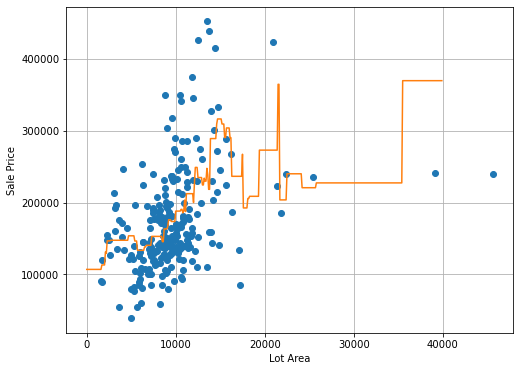

In [19]:
#set up the plot
plt.figure(figsize=(8,6))
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')
plt.grid(True)

#plot the test data using the most relevant feature
plt.plot(X_test,y_test,'o')

x = np.arange(0,40000,100)
y = regr.predict(x.reshape(-1,1))
plt.plot(x,y)
plt.show()

Finally, we plot the performance of the model as the forest is developed. We can clerly see at which point overfitting begins to occur.

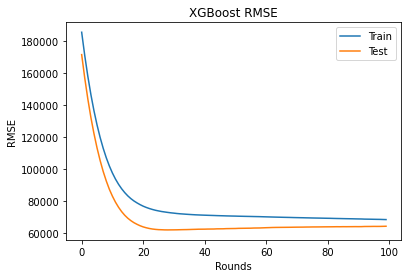

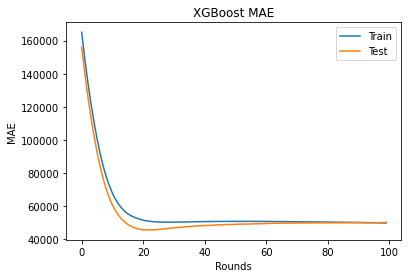

In [20]:
# retrieve performance metrics
results = regr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot RMSE
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

# plot error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.xlabel('Rounds')
plt.ylabel('MAE')
plt.title('XGBoost MAE')
plt.show()